In [1]:
import numpy as np
import qmsc.hamiltonian as ham
import qmsc.qstate as qstate
import qutip
import pickle
import scipy
import matplotlib.pyplot as plt

In [2]:
eps = 1 / 100
num_states = 100

def convert_to_qutip_op(np_array):
    """
    Converts a numpy array to a Qutip object.
    """
    shape = np_array.shape[0]
    ket_dim = [2 for _ in range(int(np.log2(shape)))]
    bra_dim = [2 for _ in range(int(np.log2(shape)))]
    dims = [ket_dim, bra_dim]
    
    return qutip.Qobj(np_array, dims)

## Generate the fixed ensemble of Bures random states

In [3]:
def gen_ginibre_matrix(m, n):
    """
    Forms random Ginibre 
    (complex) matrix.
    """
    real = np.random.normal(size=(m, n))
    imag = np.random.normal(size=(m, n))
    G = real + 1j * imag
    
    return G

def gen_bures_rand_mixed_state(n):
    """
    Generation of a random density matrix over [n] qubits
    distributed according to the probability measure
    induced by the Bures metric.
    Note: Produces stats up to rank 2**n.
    Note2: Generally, much lower rank, though. 
    """
    d = 2**n
    G = gen_ginibre_matrix(d, d)
    U = qstate.utils.gen_haar_random_unitary(n)
    idn = np.identity(d)
    a = np.matmul((idn + U), G)
    b = np.matmul(G.conj().transpose(), (idn + U.conj().transpose()))
    rho = np.matmul(a, b)
    rho /= np.trace(rho)
    
    return convert_to_qutip_op(rho)

In [4]:
bures_fname = "random_bures_states.pkl"
bures_dict = {}
for j in range(num_states):
    for n in range(1, 6):
        rho = gen_bures_rand_mixed_state(n)
        energies = rho.eigenenergies()
        re = sum(energies > eps)
        bures_dict[(n, j)] = (rho, re)
        
with open(bures_fname, 'wb') as f:
    pickle.dump(bures_dict, f)

## Generate the fixed ensemble of Hilbert-Schmidt random states

In [5]:
def gen_hs_rand_mixed_state(n):
    """
    Generation of a random density matrix on [n] qubits distributed according to 
    induced probability measure μ{2**n,k} obtained by tracing out an ancillary 
    system of dimension [k].
    Note: Produces stats up to rank k. 
    Note2: When k = 2**n, we get uniform sampling over D_HS metric.
    """
    d = 2**n
    G = gen_ginibre_matrix(d, d)
    rho = np.matmul(G, G.conj().transpose())
    rho /= np.trace(rho)
    
    return convert_to_qutip_op(rho)

In [6]:
hs_fname = "random_hilbertschmidt_states.pkl"
hs_dict = {}
for j in range(num_states):
    for n in range(1, 6):
        rho = gen_hs_rand_mixed_state(n)
        energies = rho.eigenenergies()
        re = sum(energies > eps)
        hs_dict[(n, j)] = (rho, re)
        
with open(hs_fname, 'wb') as f:
    pickle.dump(hs_dict, f)

## Generate random XY chains with open boundary conditions

In [7]:
def make_xy_chain_hamiltonian(n, rand=0):
    """
    Makes [n] qubit XY model.
    """
    qpairs = [(q, q + 1) for q in range(n - 1)]
    if rand == 0:
        Jx = [1 for _ in range(n - 1)]
        Jy = Jx
    else:
        Jx = np.random.normal(size = n - 1)
        Jy = np.random.normal(size = n - 1)
    return ham.utils.make_xy_hamiltonian(qpairs, Jx, Jy, n)

def form_xy_thermal_state(n, temp, rand=0):
    """
    Forms rho^{(XY)}_{(thermal)} state.
    """
    xy_ham = make_xy_hamiltonian(n, rand)
    beta = 1 / temp
    gibbs_op = scipy.linalg.expm(-beta * xy_ham)
    norm = np.trace(gibbs_op)
    
    return convert_to_qutip_op(gibbs_op / norm)

In [8]:
T = 0.05
xy_fname = f"random_xy_T_{T}_states.pkl"
xy_dict = {}
for j in range(num_states // 4):
    for n in range(2, 10):
        rho = form_xy_thermal_state(n, T, 1)
        energies = rho.eigenenergies()
        re = sum(energies > eps)
        xy_dict[(n, T, j)] = (rho, re)
            
with open(xy_fname, 'wb') as f:
    pickle.dump(xy_dict, f)

In [7]:
T = 10 * 0.05
xy_fname = f"random_xy_T_{T}_states.pkl"
xy_dict = {}
for j in range(num_states // 4):
    for n in range(2, 10):
        rho = form_xy_thermal_state(n, T, 1)
        energies = rho.eigenenergies()
        re = sum(energies > eps)
        xy_dict[(n, T, j)] = (rho, re)
            
with open(xy_fname, 'wb') as f:
    pickle.dump(xy_dict, f)

In [8]:
T = 100 * 0.05
xy_fname = f"random_xy_T_{T}_states.pkl"
xy_dict = {}
for j in range(num_states // 4):
    for n in range(2, 10):
        rho = form_xy_thermal_state(n, T, 1)
        energies = rho.eigenenergies()
        re = sum(energies > eps)
        xy_dict[(n, T, j)] = (rho, re)
            
with open(xy_fname, 'wb') as f:
    pickle.dump(xy_dict, f)

## Scratch of playing around with ranks and whatnot

In [10]:
n = 9
T = 0.05
states = []
eps_rank = []
purity = []
for _ in range(25):
    rho = form_xy_thermal_state(n, T, 1)
    states.append(rho)
    purity.append(rho.purity())
    energies = rho.eigenenergies()
    re = sum(energies > eps)
    eps_rank.append(re)

(array([18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.]),
 array([2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
 <BarContainer object of 10 artists>)

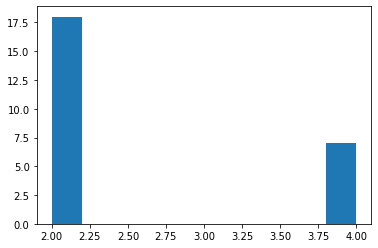

In [11]:
plt.hist(eps_rank)

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  3., 18.]),
 array([0.2850293 , 0.30652637, 0.32802344, 0.34952051, 0.37101758,
        0.39251465, 0.41401172, 0.43550879, 0.45700586, 0.47850293,
        0.5       ]),
 <BarContainer object of 10 artists>)

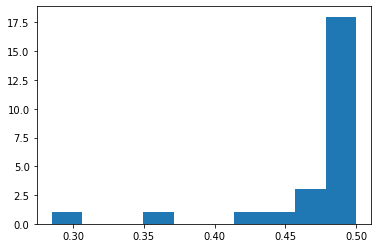

In [89]:
plt.hist(purity)

In [90]:
n = 9
T = 10 * 0.05
states = []
eps_rank = []
purity = []
for _ in range(25):
    rho = form_xy_thermal_state(n, T, 1)
    states.append(rho)
    purity.append(rho.purity())
    energies = rho.eigenenergies()
    re = sum(energies > eps)
    eps_rank.append(re)

(array([2., 0., 7., 0., 3., 0., 4., 0., 7., 2.]),
 array([ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.]),
 <BarContainer object of 10 artists>)

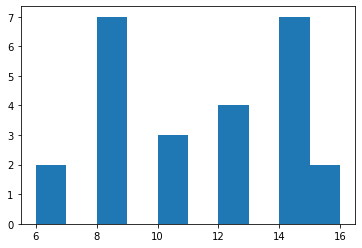

In [91]:
plt.hist(eps_rank)

(array([9., 4., 1., 2., 2., 1., 3., 1., 0., 2.]),
 array([0.09915882, 0.12153305, 0.14390728, 0.16628151, 0.18865574,
        0.21102997, 0.2334042 , 0.25577843, 0.27815266, 0.30052689,
        0.32290112]),
 <BarContainer object of 10 artists>)

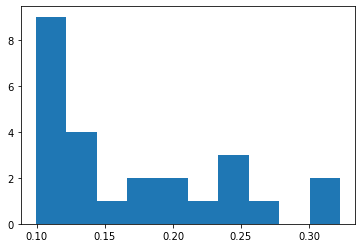

In [92]:
plt.hist(purity)

In [99]:
n = 5
T = 100 * 0.05
states = []
eps_rank = []
purity = []
for _ in range(25):
    rho = form_xy_thermal_state(n, T, 1)
    states.append(rho)
    purity.append(rho.purity())
    energies = rho.eigenenergies()
    re = sum(energies > eps)
    eps_rank.append(re)

(array([ 1.,  0.,  0.,  0.,  3.,  0.,  1.,  0.,  7., 13.]),
 array([22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.]),
 <BarContainer object of 10 artists>)

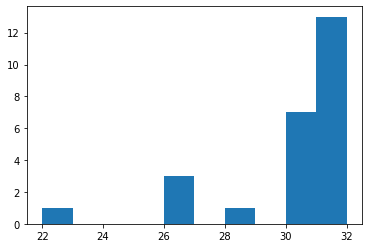

In [100]:
plt.hist(eps_rank)

(array([2., 6., 6., 3., 3., 1., 2., 0., 1., 1.]),
 array([0.03481993, 0.0368968 , 0.03897366, 0.04105053, 0.0431274 ,
        0.04520427, 0.04728114, 0.049358  , 0.05143487, 0.05351174,
        0.05558861]),
 <BarContainer object of 10 artists>)

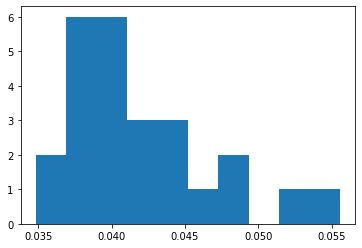

In [101]:
plt.hist(purity)

In [118]:
init_beta = 1e-3

# small system sizes xy model inputs
small_xy_input_list = []
na_choices = 0
max_perturbations = 0
opt_tol = 1e-16
diff_tol = 1e-8
s_lidx = 0
s_uidx = 24
state_types = ["xy_T_0.05", "xy_T_0.5", "xy_T_5.0"]
for ns in range(1, 3):
    time = "1:00:00"
    job_name = f"xy_{ns}"
    for st in state_types:
        inp = [st, ns, s_lidx, s_uidx, na_choices, max_perturbations, opt_tol,
               diff_tol, init_beta, time, job_name]

In [120]:
inp = [str(x) for x in inp]

In [124]:
float(inp[-4])

1e-08

In [25]:
re = 9
na = int(np.ceil(np.log2(re)))
if na == 0:
    na += 1
R = 2**na
print(re, na, R)

9 4 16


In [ ]:
4